## Import Standard Numeric & Plotting Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_palette("Set1")

## Create a Synthetic Dataset

### Pure spectra

In [8]:
wavel = np.arange(290, 510, 3)
spec1 = np.exp(-((wavel - 380) / 30) ** 2)
spec2 = np.exp(-((wavel - 430) / 16) ** 2)
P = np.c_[spec1, spec2]

### Concentration Profiles

In [6]:
Nobs = 20
obs = np.arange(Nobs)
c1 = 0.7 * np.exp(-(obs / 5) ** 2) + 0.15
c2 = 1 - c1
C = np.c_[c1, c2]

### the "Measurements": That will be fed into MCR

In [10]:
M = P @ C.T

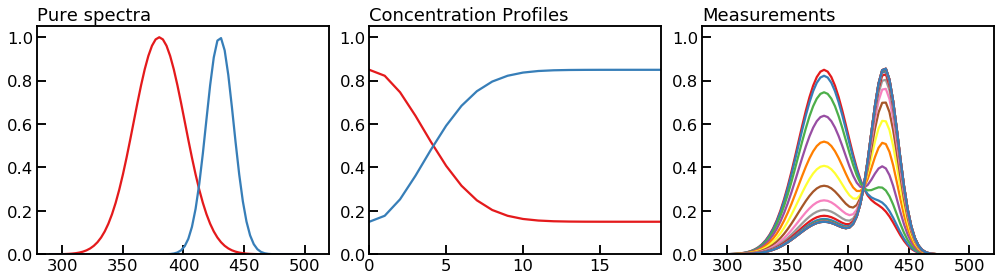

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(wavel, spec1)
ax1.plot(wavel, spec2)
ax1.set_title('Pure spectra', loc='left')

ax2.plot(obs, c1)
ax2.plot(obs, c2)
ax2.set_xlim(0, Nobs - 1)
ax2.set_title('Concentration Profiles', loc='left')

for i in range(Nobs):
    ax3.plot(wavel, M[:, i])
    
ax3.set_title("Measurements", loc='left')

ax1.set_ylim(0, 1.05)
ax2.set_ylim(0, 1.05)
ax3.set_ylim(0, 1.05)
fig.tight_layout()

## Import MCR & EFA codes

In [14]:
from mcr import MCR
from mcr.efa import efa

### EFA for initial guess

In [19]:
C_ = efa(M, ncomp=2, plot=False)

### Normalize such that total concentration is always 1, as in standardized XANES. Then plot the initial guess against reality.

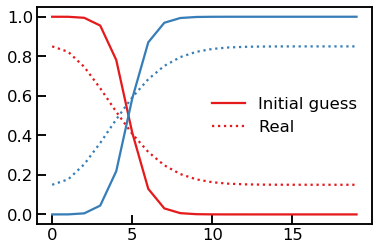

In [21]:
C_ /= C_.sum(axis=1)[:, None]
l1 = plt.plot(obs, C_[:, 0], label='Initial guess')[0]
l2 = plt.plot(obs, C_[:, 1])[0]

plt.plot(obs, C[:, 0], ':', color=l1.get_color(), label='Real')
plt.plot(obs, C[:, 1], ':', color=l2.get_color())

plt.legend(framealpha=False)

## Create the mcr object that will do the job

Default regressors:
- Non-negative results for the predicted spectra
- Non-negative results that sum up to 1 for the concentration profiles


- `maxiter`: maximum number of iterations
- `chkpnt` : number of iterations in between convergence check
- `tol`    : convergence threshold

In [23]:
mcr = MCR(maxiter=1000, chkpnt=10, tol=1e-10)

## Run MCR

- `M` is the measurements matrix.
- `C_` is the initial guess from EFA.
- `debug=True` keeps the error from every `chkpnt` iterations

In [25]:
mcr.fit(M, C=C_, debug=True)
print(f"MCR is converged: {mcr.converged}")

MCR is converged: True


## Plot the results

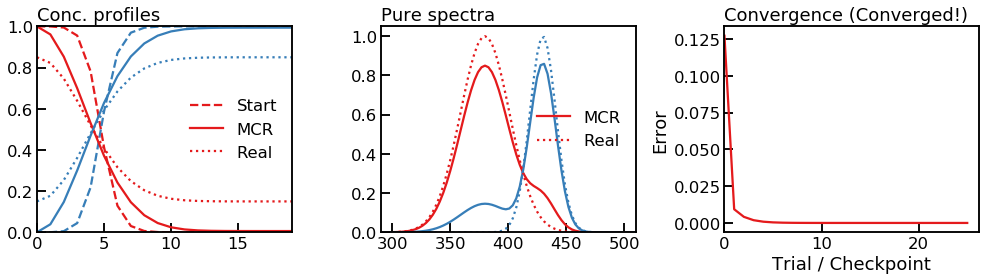

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

l1 = ax1.plot(obs, C_[:, 0], "--", label="Start")[0]
l2 = ax1.plot(obs, C_[:, 1], "--")[0]
ax1.plot(obs, mcr.C[:, 0], color=l1.get_color(), label="MCR")
ax1.plot(obs, mcr.C[:, 1], color=l2.get_color())
ax1.plot(obs, C[:, 0], ":", color=l1.get_color(), label="Real")
ax1.plot(obs, C[:, 1], ":", color=l2.get_color())
ax1.set_xlim(0, Nobs - 1)
ax1.set_ylim(0, 1)
ax1.legend(framealpha=False)
ax1.set_title("Conc. profiles", loc='left')

ax2.plot(wavel, mcr.B[:, 0], color=l1.get_color(), label="MCR")
ax2.plot(wavel, mcr.B[:, 1], color=l2.get_color())
ax2.plot(wavel, B[:, 0], ":", color=l1.get_color(), label="Real")
ax2.plot(wavel, B[:, 1], ":", color=l2.get_color())
ax2.legend(framealpha=False)
ax2.set_xlim(290, 510)
ax2.set_ylim(0, 1.05)
ax2.set_title("Pure spectra", loc='left')

ax3.plot(mcr.error)
ax3.set_xlabel("Trial / Checkpoint")
ax3.set_xlim(left=0)
ax3.set_ylabel("Error")
ax3.set_title(f'Convergence ({"" if mcr.converged else "Not "}Converged!)', loc='left')

fig.tight_layout()